# Quantum Phase Estimation

This example provides an implementation of the Quantum Phase Estimation (QPE) algorithm using the Amazon Braket SDK.
The Quantum Phase Estimation algorithm is designed to estimate the eigenvalues of a unitary operator $U$ [1, 2]; 
It is a very important subroutine to many quantum algorithms, most famously Shor's algorithm for factoring and the HHL algorithm (named after the physicists Harrow, Hassidim and Lloyd) for solving linear systems of equations on a quantum computer [1, 2]. 
Moreover, eigenvalue problems can be found across many disciplines and application areas, including principal component analysis (PCA) as used in machine learning or the solution of differential equations as relevant across mathematics, physics, engineering and chemistry. 
This notebook implements the Quantum Phase Estimation algorithm in code using the Amazon Braket SDK and run a simple example. 


## References

[[1] Quantum Algorithm Implementations for Beginners](https://arxiv.org/abs/1804.03719)

[[2] Wikipedia Quantum_phase_estimation_algorithm](https://en.wikipedia.org/wiki/Quantum_phase_estimation_algorithm)

In [1]:
import matplotlib.pyplot as plt
#from braket.aws import AwsDevice
from braket.circuits import Circuit, circuit
from braket.devices import LocalSimulator

from braket.experimental.algorithms.quantum_phase_estimation import (
    get_quantum_phase_estimation_results,
    run_quantum_phase_estimation,
    quantum_phase_estimation_circuit,
)

# magic word for producing visualizations in notebook
%matplotlib inline
%load_ext autoreload
%autoreload 2

## Prepare Quantum Phase Estimation inputs

The QPE algorithm requires two input register and a unitary on which you want to estimate eigenvalues. The first register is the precision register with n qubits which sets the achievable precision of results.
The second is the query register which hosts the eigenstate.

In [2]:
# Define a callback function to apply your controlled unitary to a given circuit.
# This is used by the Quantum Phase Estimation algorithm to apply your controlled unitary.
# To run on a QPU this controlled unitary needs to be decomposed into gates available for a given QPU.
def unitary_apply_cnot_func(quantum_phase_estimation_circ, control_qubit, query_qubits):
    quantum_phase_estimation_circ.cnot(control_qubit, query_qubits)

In [3]:
# Define first (precision) and second (query) registers. Qubits must be contiguous.
# Braket simulator and Quantum Phase Estimation post procssing logic assumes contiguous qubits.
precision_qubits = [0, 1]
query_qubits = [2]

# The query register needs to be prepared in an eigenstate depending on the unitary chosen.
# For this example prepare the query register with Hadamard gates.
quantum_phase_estimation_circ = Circuit().h(query_qubits)

## Create and visualize the Quantum Phase Estimation circuit


In [4]:
# Now that you have prepped the unitary, precision qubits, and query qubits,
# create the quantum phase estimation circuit with all three as input.
quantum_phase_estimation_circ = quantum_phase_estimation_circuit(
    quantum_phase_estimation_circ, precision_qubits, query_qubits, unitary_apply_cnot_func
)
print("Quantum Phase Estimation Circuit:")
print(quantum_phase_estimation_circ)

Quantum Phase Estimation Circuit:
T  : │  0  │  1  │   2    │  3  │       4        │  5  │ Result Types  │
      ┌───┐                      ┌──────────────┐ ┌───┐ ┌─────────────┐ 
q0 : ─┤ H ├──────────x───────────┤ PHASE(-1.57) ├─┤ H ├─┤ Probability ├─
      └───┘          │           └──────┬───────┘ └───┘ └──────┬──────┘ 
      ┌───┐          │     ┌───┐        │               ┌──────┴──────┐ 
q1 : ─┤ H ├───●──────x─────┤ H ├────────●───────────────┤ Probability ├─
      └───┘   │            └───┘                        └──────┬──────┘ 
      ┌───┐ ┌─┴─┐                                       ┌──────┴──────┐ 
q2 : ─┤ H ├─┤ X ├───────────────────────────────────────┤ Probability ├─
      └───┘ └───┘                                       └─────────────┘ 
T  : │  0  │  1  │   2    │  3  │       4        │  5  │ Result Types  │


## Run on a local simulator

In [5]:
# define device and run quantum phase estimation
device = LocalSimulator()
print("Quantum Phase Estimation Running")
task = run_quantum_phase_estimation(quantum_phase_estimation_circ, device)
print("Quantum Phase Estimation Run Complete")
# pretty print results. Comment out these lines if you don't want results printed
print("Quantum Phase Estimation Results:")
agg_result = get_quantum_phase_estimation_results(
    task, precision_qubits, query_qubits, verbose=True
)
# plot probabalities
plt.bar(agg_result["bitstring_keys"], agg_result["probs_values"])
plt.xlabel("bitstrings")
plt.ylabel("probability")
plt.xticks(rotation=90)
print("Measurement Counts Graph:")

Quantum Phase Estimation Running
Quantum Phase Estimation Run Complete
Quantum Phase Estimation Results:
Measurement counts: Counter({'001': 502, '000': 498})
Results in precision register: {'00': 1000}
Quantum phase estimation phase estimates: [0.0]
Quantum phase estimation eigenvalue estimates: [1.+0.j]
Measurement Counts Graph:


## Run on a Managed Simulator or QPU
The call to run on the QPU device is commented out by default and instead runs on a managed simulator. See the follow cells to switch to run on a QPU.
Note that 1) this may take time depending on QPU availability and 2) results will be noisy relative to the simulator run.

In [6]:
# Use Braket SDK Cost Tracking to estimate the cost to run this example
from braket.tracking import Tracker

tracker = Tracker().start()

Quantum Phase Estimation Running
Quantum Phase Estimation Run Complete
Quantum Phase Estimation Results:
Measurement counts: Counter({'000': 505, '001': 495})
Results in precision register: {'00': 1000}
Quantum phase estimation phase estimates: [0.0]
Quantum phase estimation eigenvalue estimates: [1.+0.j]
Measurement Counts Graph:


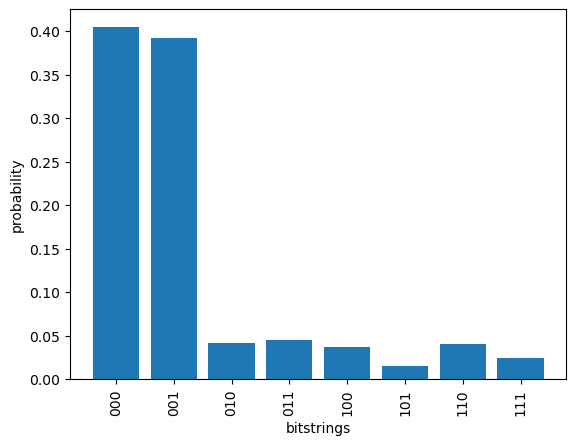

In [7]:
# define device and run quantum phase estimation
# managed_device = AwsDevice('arn:aws:braket:us-west-1::device/qpu/rigetti/Ankaa-2')
managed_device = AwsDevice("arn:aws:braket:::device/quantum-simulator/amazon/sv1")
print("Quantum Phase Estimation Running")
task = run_quantum_phase_estimation(quantum_phase_estimation_circ, managed_device, shots=1000)
print("Quantum Phase Estimation Run Complete")
# pretty print results
print("Quantum Phase Estimation Results:")
agg_result = get_quantum_phase_estimation_results(
    task, precision_qubits, query_qubits, verbose=True
)
# plot probabalities
plt.bar(agg_result["bitstring_keys"], agg_result["probs_values"])
plt.xlabel("bitstrings")
plt.ylabel("probability")
plt.xticks(rotation=90)
print("Measurement Counts Graph:")

In [8]:
print("Task Summary")
print(f"{tracker.quantum_tasks_statistics()} \n")
print(
    f"Estimated cost to run this example: {tracker.qpu_tasks_cost() + tracker.simulator_tasks_cost():.2f} USD"
)

Task Summary
{'arn:aws:braket:::device/quantum-simulator/amazon/sv1': {'shots': 1000, 'tasks': {'COMPLETED': 1}, 'execution_duration': datetime.timedelta(microseconds=5000), 'billed_execution_duration': datetime.timedelta(seconds=3)}} 

Estimated cost to run this example: 0.00 USD


Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).